# MiniGato

From the paper [A Generalist Agent](https://arxiv.org/abs/2205.06175).

The paper doesn't introduce a new architecture. Instead, the paper is all about tokenizing, embedding, and sequencing data from multiple modalities (text, image, proprioception) in such a way that it can be learned by a transformer.

Reproducing the paper is more of a software design exercise than an ML research exercise. How would you structure the data manipulation code – the tokenization, embedding, and sequencing of different modalities – in a way that's correct, easy to understand and extend, and performant?

### Imports

In [6]:
from abc import ABC, abstractmethod
from collections import defaultdict, OrderedDict
from itertools import cycle
import math
import os
from pathlib import Path
import pdb
import random
import re
import tempfile
from typing import List, Protocol
from dataclasses import dataclass, fields
import datasets
from einops import rearrange
from functools import partial
from mugato.nano_gpt import GPT, GPTConfig
import numpy as np
import matplotlib.pyplot as plt
import minari
from mugato.util import (
    tensor_as_gif, TransformDataset,
    images_to_patches, patches_to_images, normalize_to_between_minus_one_plus_one,
    apply_along_dimension, discretize, undiscretize,
    interleave, deinterleave,
)
import minigrid.core
import PIL
import random
import requests
from timm.models.resnetv2 import ResNetV2
import tiktoken
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor as _pil_to_tensor
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
torch.manual_seed(42)
random.seed(42)

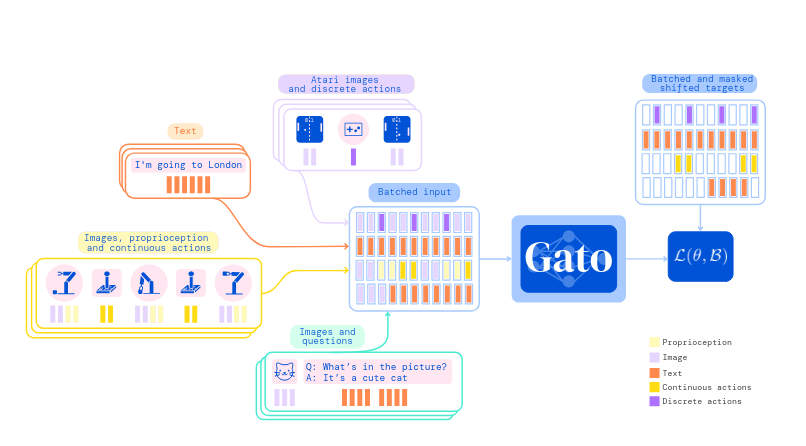

### Tokenizing and sequencing

We're going to be dealing with a bunch of different datasets of a bunch of different modalities.

Here's some examples

- A text dataset where each sample is a UTF-8 string.
- A visual-question answering dataset where each sample is a dictionary of image (PIL format), question, and answer.
- A visual-question answering dataset where each sample is a dictionary of image, question, and a list of 10 answers of different confidence levels.
- A grid-world dataset where each sample is a sequence of observations, where each observation is a dictionary of discrete view of the world, discrete state of the agent, and action the agent took.

If we can find a common format, a common shape, between all of our datasets, then our model will remain simple. That's what we want. We want to minimze the complexity of our model, so it's easy to verify it's working correctly; easy to experiment with.

A batch of text data might start out as something like:

```
[
  ["Four score and seven years ago..."],
  ["There once was a man from Nantucket..."],
  ["Lorem ipsum dolor sit amet..."],
]
```

Which might get tokenized (with padding) as a shape (3, 11) batch of tensors:

```
tensor([[15137,  4776,   290,  3598,   812,  2084,   986,     0,     0,     0,     0],
        [ 1858,  1752,   373,   257,   582,   422,   399,   415, 38811,   986,     0],
        [   43, 29625,   220,  2419,   388,   288, 45621,  1650,   716,   316,   986]])
```

And then embedded to something like (3, 512) if we have 512 embedding dimensions.

That's simple enough. We could send that straight into a model.

What about an agent episode?

```
[
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479>",
            "observation_direction": 0,
            "action": 2,
        },
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479>",
            "observation_direction": 1,
            "action": 1,
        },
        # ...
    ],
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>",
            "observation_direction": 1,
            "action": 3,
        },
        # ...
    ],
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x458>",
            "observation_direction": 0,
            "action": 1,
        },
        # ...
    ],
]
```

That's going to be trickier.

Consider the first sample in that batch.

The GATO paper describes sequencing each episode like this:

```
[<observation_image_0>, <observation_direction_0>, <action_separator_0>, <action_0>, <observation_image_1>, <observation_direction_1>, <action_separator_1>, <action_1>, ...]
```

That would be great if each of those placeholders expanded to a single token, or even a list of tokens.

The `direction` and `action` will get tokenized to a number at the end of the text tokenizers vocab size. [[§2.1 Tokenization](https://arxiv.org/pdf/2205.06175#page=3)]

```
[<observation_image_0>, 50257, 51281, 50258, ...]
```

But think about how you encode an image as "tokens".

The paper describes splitting an image into "patches". 16x16 of them. Each patch then gets sent through ResNetV2. Each "token" is more like an "embedding" in terms of its shape.

```
[[[0.13... -0.54..., 0.79...], [0.03... 0.67..., 0.88...], ...], 50257, 51281, 50258, ...]
```

You can't really *sequence* those like you could text. Not yet at least. Not as tensors - you'd need each token to have the same shape to concat them. Once you embed discrete values using a lookup table, then you can combine the images and text into a sequence. But until then, we'll have to keep them separated.

In [11]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*4).view(2, 4, 1),
        # Images look like this:
        #
        #                                      Episodes
        #                                      |  Height
        #                                      |    |    Width
        #                                      |    |    |  Channels
        #                                      |    |    |  |
        'image': torch.randn(2*256*256*3).view(2, 256, 256, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*3).view(3, 3, 1),
        'image': torch.randn(3*256*256*3).view(3, 256, 256, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

Those examples would be batched (collated?) to actually look like the following.

Notice that padding.

- The first example had its ***episodes*** padded to 3.
- The second example had its ***mission tokens*** padded to 4.

In [ ]:
batch = {
    # Continuous/Discrete/Text looks like this:
    #                                   Batch
    #                                   |  Episodes
    #                                   |  |  Tokens
    #                                   |  |  |  Channels
    #                                   |  |  |  |
    'mission': torch.arange(2*3*4).view(2, 3, 4, 1),
    # Images look like this:
    #                                        Batch
    #                                        |  Episodes
    #                                        |  |  Height
    #                                        |  |    |  Width
    #                                        |  |    |    |  Channels
    #                                        |  |    |    |  |
    'image': torch.randn(2*3*256*256*3).view(2, 3, 256, 256, 3),
    'action': torch.arange(2*3*1).view(2, 3, 1, 1),
}

### Setup

Boilerplate utility functions to help with demos/examples. (You'll see these redefined later. I need the code now due to way code cells run linearly. But I don't want to show the details until later.)

In [8]:
def pil_to_tensor(p):
    return _pil_to_tensor(p) if isinstance(p, PIL.Image.Image) else p
# I'm going to load some datasets early so that we have some examples to work with as we build stuff.

def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)

    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

shakespeare_dataset = acquire_shakespeare_dataset()
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [9]:
shakespeare_dataset[0]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175)

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream.

Some of this notebook deviates slightly (insignificantly, I expect) from the Gato paper.

- Text is encoded via `tiktoken`'s [r50k_base](https://github.com/openai/tiktoken/blob/63527649963def8c759b0f91f2eb69a40934e468/tiktoken_ext/openai_public.py#L33)
- Images are transformed into sequences of non-overlapping 16x16 patches in raster order, as done in [ViT (Dosovitskiy et al., 2020)](https://arxiv.org/pdf/2010.11929).
- Discrete values, e.g. Atari button presses, are flattened into sequences of integers within the range [50257, 51280) – the 1023 tokens after the text tokenizer's range. Discrete token 51281 (the 1024th discrete token) is used as the separator token between an observation and an action.
- Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values, then mu-law encoded to the range [-1, 1], then discretized into 1024 uniform bins, then encoded the same as discrete values.
- Discrete observations that represent a grid-like environment (i.e. [Minigrid](https://minigrid.farama.org/environments/minigrid/)) are transformed into images and encoded as such. This might be the most significant change. The Gato paper describes flattening these types of discrete observation values. That loses the benefit of neighboring column/row patch position encoding of images. Plus this is extra image training data for free.

### Tokenizing images

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

We'll use 144 patches (12 by 12) to keep our model a bit smaller and faster. The patch size will still be 16. That means our images need to be resized to 192 by 192 before patching.

In [10]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [11]:
image_transform = transforms.Compose([
    pil_to_tensor,
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
])

In [12]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [13]:
xs = torch.arange(-2, 5)
normalize_to_between_minus_one_plus_one(xs)

tensor([-1.0000, -0.6667, -0.3333,  0.0000,  0.3333,  0.6667,  1.0000])

In [14]:
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [15]:
example = torch.arange(8).view(2, 2, 2)
print(f"starting tensor:\n{example}\n")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}\n")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}\n")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}\n")

starting tensor:
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]]])

t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]]])

t * t.min() along dim 2:
tensor([[[ 0,  0],
         [ 4,  6]],

        [[16, 20],
         [36, 42]]])



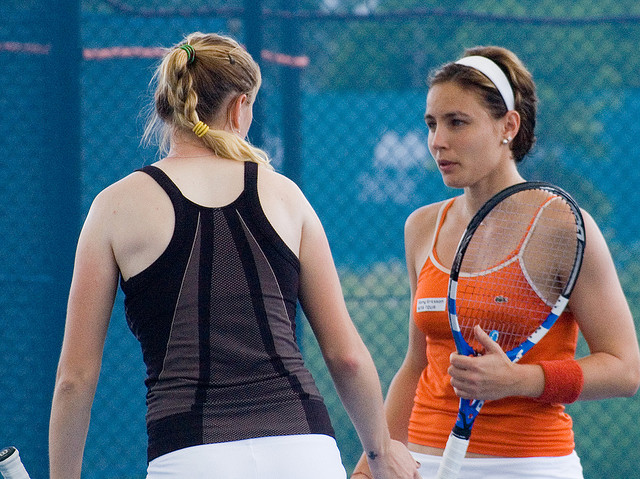

In [16]:
example_image = vqa_dataset['train'][0]['image']
example_image

In [17]:
def image_to_patches(image, patch_size=16):
    return rearrange(image, 'c (h s1) (w s2) -> (h w) (c s1 s2)', s1=16, s2=16)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches,
        '(h w) (c p1 p2) -> c (h p1) (w p2)',
        h=12,
        w=12,
        c=3,
        p1=16,
        p2=16,
    )
    return reconstructed

In [18]:
example_image_patches = image_to_patches(image_transform(example_image))
image_transform(example_image).shape, example_image_patches.shape

(torch.Size([3, 192, 192]), torch.Size([144, 768]))

In [19]:
patches_matplotlib_dims = rearrange(example_image_patches, 'p (s0 s1 s2) -> p s1 s2 s0', s0=3, s1=16, s2=16)
patches_matplotlib_dims.shape

torch.Size([144, 16, 16, 3])

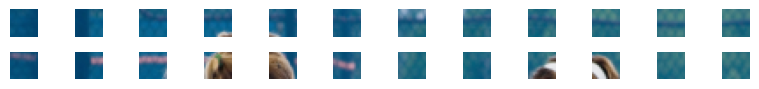

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=12, figsize=(8, 1))

for i in range(2):
    for j in range(12):
        axes[i, j].imshow(patches_matplotlib_dims[i*12+j])
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

In [21]:
def encode_image(image, patch_size=16):
    patches = image_to_patches(image, patch_size=patch_size)
    xs = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 1, patches
        )
        / math.sqrt(patch_size)
    )
    return xs

def decode_image(tokens, image_shape=(3, 192, 192), patch_size=16):
    # Slightly lossy because I'm not saving the values used for scaling from encoding.
    patches = (tokens * math.sqrt(patch_size) + 1) / 2
    images = patches_to_image(patches, image_shape, patch_size=patch_size)
    return images

In [22]:
sample_image_encoded = encode_image(image_transform(example_image))
sample_image_encoded.shape, sample_image_encoded.mean(), sample_image_encoded.std()

(torch.Size([144, 768]), tensor(0.0069), tensor(0.1486))

In [23]:
decode_image(sample_image_encoded).shape

torch.Size([3, 192, 192])

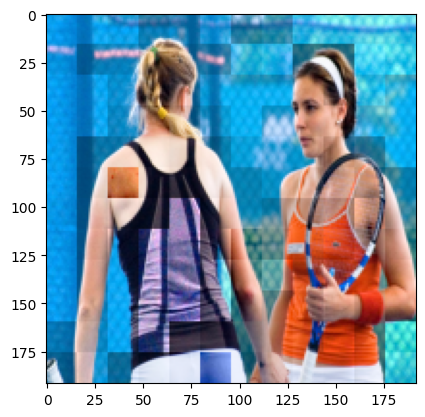

In [24]:
# Lossy because I'm not storing the min/max from normalization.
plt.imshow(decode_image(sample_image_encoded).permute(1, 2, 0))

### Tokenizing text

This one's easy.

In [25]:
# There's a bit of asymmetry between the way I encode and decode.
# When I encode, I surround the text with <|endoftext|> tokens.
# That makes it easy to slice inputs/targets. Just xs=tokens[:-1], ys=tokens[1:].
# When I decode, I just decode and return each token.
# That makes it easy to not have to think about padding the generated output before you decode.
def encode_text(text_tokenizer, text):
    tokens = torch.tensor(text_tokenizer.encode(text))
    return tokens

def decode_text(text_tokenizer, tokens):
    return text_tokenizer.decode(tokens.tolist())
text_tokenizer = tiktoken.get_encoding("r50k_base")
encode_text(text_tokenizer, "Hello, world!"), decode_text(text_tokenizer, encode_text(text_tokenizer, "Hello, world!"))

(tensor([15496,    11,   995,     0]), 'Hello, world!')

### Tokenizing discrete

> After converting data into tokens, we use the following canonical sequence ordering...
> - ...
> - Agent timesteps as observation tokens ***followed by a separator, then action tokens***. 
> - ...

In [54]:
def _to_tensor(x):
    return x if isinstance(x, torch.Tensor) else torch.tensor(x)

# Same asymmetry story as above.
def encode_discrete(tokens, offset):
    return (torch.tensor(tokens, dtype=torch.long) + offset)

def decode_discrete(tokens, offset) -> List[int]:
        return (tokens - offset).tolist()

[
    encode_discrete([0, 2, 2, 1, 3], text_tokenizer.n_vocab), 
    decode_discrete(encode_discrete([0, 2, 2, 1, 3], text_tokenizer.n_vocab), text_tokenizer.n_vocab)
]

[tensor([50257, 50259, 50259, 50258, 50260]), [0, 2, 2, 1, 3]]

### Tokenizing continuous

In [55]:
def discretize(x):
    x = _to_tensor(x)
    bins = torch.linspace(x.min(), x.max(), steps=1024)
    tokens = torch.bucketize(x, bins)
    return tokens.tolist()

# This is going to be a lossy decode. Nothing you can do about that.
def undiscretize(x, original_min, original_max):
    bins = torch.linspace(original_min, original_max, steps=1025)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers[x]

In [56]:
xs = (torch.arange(-2, 5) * 0.5).tolist()
[
    xs,
    discretize(xs),
    undiscretize(discretize(xs), min(xs), max(xs)),
]

[[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0],
 [0, 171, 342, 512, 682, 853, 1023],
 tensor([-0.9985, -0.4976,  0.0034,  0.5015,  0.9995,  1.5005,  1.9985])]

In [57]:
# TODO:
# The paper says to mu-law encode continuous values.
# We're not doing that yet.
def encode_continuous(tokens, offset) -> torch.Tensor:
    return encode_discrete(discretize(tokens), offset)

def decode_continuous(tokens, offset, original_min, original_max):
    return undiscretize(decode_discrete(tokens, offset), original_min, original_max)

In [58]:
[
    xs,
    encode_continuous(xs, text_tokenizer.n_vocab),
    decode_continuous(encode_continuous(xs, text_tokenizer.n_vocab), text_tokenizer.n_vocab, min(xs), max(xs))
]

[[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0],
 tensor([50257, 50428, 50599, 50769, 50939, 51110, 51280]),
 tensor([-0.9985, -0.4976,  0.0034,  0.5015,  0.9995,  1.5005,  1.9985])]

**TODO** Decode based on type.

You don't need to have the `four_rooms_tokenizer` function call `tokenizer.encode_text` for its "mission" and `tokenizer.encode_discrete` for its "direction".

You could just call `tokenizer.encode(sample)` and have the tokenizer iterate over all the key/value pairs in the sample and encode each based on the type of the value.

In [59]:
class TextTokenizer(Protocol):
    n_vocab: int
    eot_token: int
    def encode(self, text: str) -> List[int]:
        ...
    def decode(self, tokens: List[int]) -> str:
        ...

class Tokenizer:
    def __init__(self, text_tokenizer: TextTokenizer):
        self.text_tokenizer = text_tokenizer
        self.eot_token_id = text_tokenizer.eot_token
        self.eot_token = text_tokenizer.decode([self.eot_token_id])
        self.n_text = text_tokenizer.n_vocab
        self.n_discrete = 1024
        self.separator = self.boa_token = 1023  # Separator between observation and action.
        self.vocab_size = self.n_text + self.n_discrete

    def encode_text(self, text):
        return encode_text(self.text_tokenizer, text).unsqueeze(-1)

    def decode_text(self, tokens):
        return decode_text(self.text_tokenizer, tokens.squeeze(-1))
        
    def encode_discrete(self, xs):
        return encode_discrete(xs, self.n_text).unsqueeze(-1)
        
    def decode_discrete(self, tokens):
        return decode_discrete(tokens.squeeze(-1), self.n_text)

    def encode_continuous(self, xs, is_action=False):
        return encode_continuous(xs, self.n_text).unsqueeze(-1)

    def decode_continuous(self, tokens):
        return decode_continuous(tokens.squeeze(-1), self.n_text, original_min, original_max)

    def encode_image(self, image, patch_size=16):
        return encode_image(image, patch_size)
    
    def decode_image(self, tokens, image_shape=(3, 192, 192), patch_size=16):
        return decode_image(tokens, image_shape, patch_size)  

#### Examples

Think about how you would tokenize and batch the examples below?

Keep in mind: samples might have different numbers of episodes and different numbers of tokens for a given key ('mission', 'image', 'action', etc...)

- One sample might have 19 episodes with a mission of "reach the goal".
- Another sample might have 12 episodes with a mission of "find the green key".
- Another might have 17 episodes where the first 10 have a mission of "find the green key" and the last 7 have a mission of "exit through the green door".

All of that means you're going to have to pad along several different dimensions.

Note that we can't stack these until both pad _and_ embed.

In [60]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*3).view(2, 3, 1),
        # Images look like this:
        #
        #                                  Episodes
        #                                  |  Height
        #                                  |  |  Width
        #                                  |  |  |  Channels
        #                                  |  |  |  |
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*4).view(3, 4, 1),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

In [61]:
tokenizer = Tokenizer(text_tokenizer)

In [62]:
tokens = tokenizer.encode_text("Hello, world!")
tokens.shape, tokens

(torch.Size([4, 1]),
 tensor([[15496],
         [   11],
         [  995],
         [    0]]))

In [63]:
tokenizer.decode_text(tokens)

'Hello, world!'

In [64]:
tokens = tokenizer.encode_discrete([0, 1, 2, 3])
tokens.shape, tokens

(torch.Size([4, 1]),
 tensor([[50257],
         [50258],
         [50259],
         [50260]]))

In [65]:
tokenizer.decode_discrete(tokens)

[0, 1, 2, 3]

## Image prep

Resizing, cropping, and normalization aren't unique to Gato. This is just some of the general data prep you'd use for any ML training.

In [66]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [67]:
image_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    normalize,
])

## Padding and slicing to fit context window

In [68]:
SEQUENCE_LENGTH = 1024

#### A brief note on sequencing

Take a look at an example agent dataset: [Four Rooms](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/).

You've got an observation space of `[mission, direction, image]`.

In [69]:
class Timesteps(OrderedDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = 'cpu'
    def to(self, device):
        self.device = device
        for k, v in self.items():
            self[k] = v.to(device)
        return self

In [70]:
# These next 5 functions are helpers for when we need have a sample with
# a large number of episodes and creating a sequence from all of them would
# be larger than our context window.
#
# These helpers pick a random index for an episode from the sample
# and then slice up to the greatest index that's within our max sequence length.

def episode_num_tokens(sample):
    return sum([len(v[0]) for v in sample.values()])

def sample_num_tokens(sample):
    return episode_num_tokens(sample) * next(iter(sample.values())).size(0)

def sequence_episode_capacity(sequence_length, sample):
    return sequence_length // episode_num_tokens(sample)

def random_episode_start_index(sequence_length, sample):
    n_eps = next(iter(sample.values())).size(0)
    cap = min(n_eps, sequence_episode_capacity(sequence_length, sample))
    return random.randint(0, n_eps - cap)

def slice_to_context_window(sequence_length, sample):
    result = Timesteps()
    n = random_episode_start_index(1024, sample)
    m = sequence_episode_capacity(1024, sample)
    if m < 1:
        for k in sample.keys():
            result[k] = sample[k][:, :sequence_length]
    else:
        for k in sample.keys():
            result[k] = sample[k][n:n+m]
    return result

In [71]:
sample = dict(text=torch.arange(50 * 100).view(50, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

(40, 10)

In [72]:
sample = dict(text=torch.arange(1025).view(1, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

(0, 0)

In [73]:
sample['text'].shape, slice_to_context_window(1024, sample)['text'].shape

(torch.Size([1, 1025, 1]), torch.Size([1, 1024, 1]))

In [74]:
def pad(batch, padding_value=0):
    padded = {}
    for k, v in batch[0].items():
        episode_length = max(sample[k].size(0) for sample in batch)
        token_length = max(sample[k].size(1) for sample in batch)
        for sample in batch:
            pad = (0, 0, 0, token_length - sample[k].size(1), 0, episode_length - sample[k].size(0))
            padded[k] = padded.get(k, [])
            padded[k].append(F.pad(sample[k], pad, value=0))
    return Timesteps([
        (k, torch.stack(v))
        for k, v in padded.items()
    ])

def mask(batch):
    result = Timesteps()
    for k, v in batch[0].items():
        episode_lengths = [sample[k].size(0) for sample in batch]
        token_lengths = [sample[k].size(1) for sample in batch]
        result[k] = torch.zeros(len(batch), max(episode_lengths), max(token_lengths))
        for i in range(len(batch)):
            result[k][i][:episode_lengths[i], :token_lengths[i]] = 1
    return result

## Datasets

### [The Four Rooms Dataset](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/)

Each dataset will need a few customized functions to manipulate the data into something a transformer can use.

> [Observation Encoding](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/#observation-encoding)
> 
>    - Each tile is encoded as a 3 dimensional tuple: (OBJECT_IDX, COLOR_IDX, STATE)
>    - OBJECT_TO_IDX and COLOR_TO_IDX mapping can be found in minigrid/core/constants.py
>    - STATE refers to the door state with 0=open, 1=closed and 2=locked


In the case of the Four Rooms Dataset, that means converting a discrete description of a grid into an image. We probably could encode the grid as a discrete observation. But images give us spatial information thanks to the patch position encoding. Plus, it doesn't seem like it would hurt anything to have more visual data to train on.

The functions you'll need for most datasets will be:

- miscellanous manipulations, like the Four Rooms grid-observation to an image
- tokenizer
- collate function

![](https://minigrid.farama.org/_images/door-key-curriculum.gif)

In [75]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
sample = four_rooms_dataset[0]
sample.observations.keys(), sample.observations['direction'].shape, sample.observations['image'].shape, sample.actions.shape

(dict_keys(['direction', 'image', 'mission']), (20,), (20, 7, 7, 3), (19,))

In [76]:
class Timesteps(OrderedDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = 'cpu'
    def to(self, device):
        self.device = device
        for k, v in self.items():
            self[k] = v.to(device)
        return self

In [77]:
def generic_tokenize(tokenizer, episode):
    tokens = {}
    for k, v in episode.items():
        if isinstance(v, str):
            tokens[k] = tokenizer.encode_text(v)
        elif isinstance(v, list) and len(v) > 0:
            if isinstance(v[0], int):
                tokens[k] = tokenizer.encode_discrete(v)
            elif isinstance(v[0], float):
                tokens[k] = tokenizer.encode_continuous(v)
        elif isinstance(v, torch.Tensor):
            tokens[k] = tokenizer.encode_image(v)
    return tokens

In [78]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in minigrid.core.constants.IDX_TO_COLOR.items():
    lut[idx] = minigrid.core.constants.COLORS[color_name]

def four_rooms_to_rgb(images):
    """Convert discrete "image" observations into actual images.
    
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    return torch.from_numpy(lut[images[:, :, :, 1]]).permute(0, 3, 1, 2)    

def tokenize_four_rooms(tokenizer, episode):
    # slice to -1 on all observations because we have 1 more observations than actions.
    mission_tokens = [tokenizer.encode_text(mission) for mission in episode.observations["mission"][:-1]]
    direction_tokens = [tokenizer.encode_discrete([direction]) for direction in episode.observations["direction"][:-1]]
    image = episode.observations["image"][:-1]
    image = four_rooms_to_rgb(image)
    image_tokens = [tokenizer.encode_image(image) for image in image_transform(image)]
    action_tokens = [tokenizer.encode_discrete([tokenizer.separator, action]) for action in episode.actions]
    
    mission = torch.stack(mission_tokens)
    direction = torch.stack(direction_tokens) 
    image = torch.stack(image_tokens)
    action = torch.stack(action_tokens)

    xs = Timesteps({
        'mission': mission,
        'direction': direction, 
        'image': image,
        'action': action[:, :-1],
    })
    ys = Timesteps({
        'mission': torch.zeros_like(mission),
        'direction': torch.zeros_like(direction),
        # We're not predicting image patches, so we don't need "real" targets.
        # We just need something with the same channel dimensionality as our other tokens
        # so that we can concat them all together and predict on the sequenced tokens.
        'image': torch.zeros(image.size(0), image.size(1), 1),
        'action': action[:, 1:],
    })
    return xs, ys

In [79]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [80]:
four_rooms_dataset_xf = TransformDataset(four_rooms_dataset, partial(tokenize_four_rooms, tokenizer))

In [81]:
xs, ys = four_rooms_dataset_xf[0]
xs['mission'].shape, xs['action'].shape, xs['direction'].shape, xs['image'].shape

(torch.Size([19, 3, 1]),
 torch.Size([19, 1, 1]),
 torch.Size([19, 1, 1]),
 torch.Size([19, 144, 768]))

In [82]:
batch = [four_rooms_dataset_xf[i] for i in range(4)]

In [83]:
def generic_collate_fn(batch, sequence_length=1024):
    sliced = [
        (slice_to_context_window(sequence_length, xs), slice_to_context_window(sequence_length, ys))
         for xs, ys in batch
    ]
    # sliced is a (B, 2, ...) list.
    # the 2 is xs, ys
    xs, ys = [v for v in zip(*sliced)]
    xs, ys, ms = pad(xs), pad(ys), mask(ys)
    return xs, ys, ms

In [84]:
xs, ys, ms = generic_collate_fn(batch)

In [85]:
[xs[p].shape for p in xs.keys()]

[torch.Size([4, 6, 3, 1]),
 torch.Size([4, 6, 1, 1]),
 torch.Size([4, 6, 144, 768]),
 torch.Size([4, 6, 1, 1])]

In [86]:
[ys[p].shape for p in ys.keys()]

[torch.Size([4, 6, 3, 1]),
 torch.Size([4, 6, 1, 1]),
 torch.Size([4, 6, 144, 1]),
 torch.Size([4, 6, 1, 1])]

In [87]:
xs.keys()

odict_keys(['mission', 'direction', 'image', 'action'])

#### Exploring the Four Rooms dataset - Images

In [88]:
four_rooms_dataset[0].observations['image'].shape
# 20 "episodes" (or "steps" that the robot took to complete the task)
# 7x7 grid of vision at each step
# 3 "channels". NOT RGB. (object_type, object_color, object_state)

(20, 7, 7, 3)

In [89]:
# Our image transformation pipeline can random/resize/crop this to (3, 192, 192)
# just like any other image.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images.shape

torch.Size([20, 3, 7, 7])

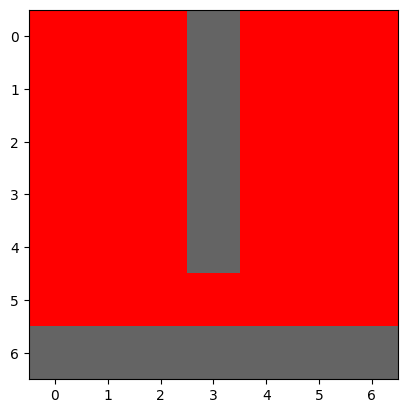

In [90]:
plt.imshow(images[0].permute(1, 2, 0))

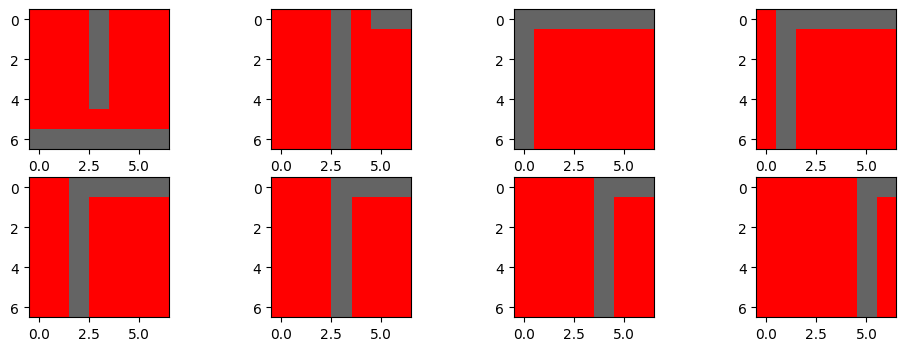

In [91]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(four_rooms_to_rgb(four_rooms_dataset[0].observations['image'][[i*4+j]])[0].permute(1, 2, 0))

In [92]:
four_rooms_dataset[0].observations['image'][[i]].shape

(1, 7, 7, 3)

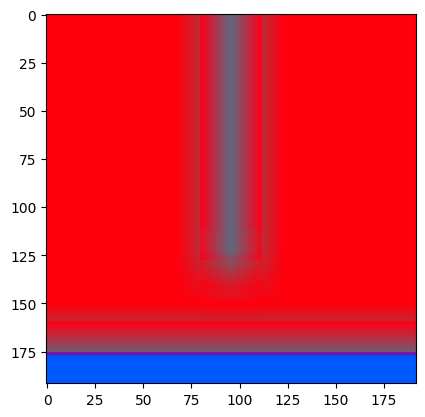

In [93]:
xs, ys = four_rooms_dataset_xf[0]
images = xs['image']
image = images[0]
patches = image
plt.imshow(tokenizer.decode_image(patches).permute(1, 2, 0))

In [94]:
image.shape, tokenizer.decode_image(image).shape

(torch.Size([144, 768]), torch.Size([3, 192, 192]))

In [95]:
from PIL import Image
from IPython.display import display, Image as IPythonImage

In [96]:
# Converting them to PIL Images gives us a convenient way to save the images as a GIF.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images = images.permute(0, 2, 3, 1).numpy()
images = [Image.fromarray(image) for image in images]
images[0]

In [97]:
import io
buffer = io.BytesIO()
images[0].save(
    buffer,
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0,
)
buffer.seek(0)
display(IPythonImage(data=buffer.getvalue(), width=192, height=192))

In [98]:
four_rooms_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [99]:
batch = next(iter(four_rooms_dataloader))

In [100]:
batch[0]['mission'].shape

torch.Size([4, 6, 3, 1])

### Visual Question Answering Dataset

In [101]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [102]:
tokenizer.eot_token_id

50256

In [103]:
def tokenize_vqa(tokenizer, sample):
    
    question = [tokenizer.encode_text(sample["question"])]
    image = [tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))]
    eot = torch.tensor([[tokenizer.eot_token_id]])
    answer = [torch.concat([eot, tokenizer.encode_text(random.choice(sample["answers"])["answer"]), eot])]
    question = torch.stack(question)
    image = torch.stack(image)
    answer = torch.stack(answer).to(torch.long)
    xs = Timesteps({
        'question': question,
        'image': image,
        'answer': answer[:, :-1],
    })
    ys = Timesteps({
        'question': torch.zeros_like(question),
        'image': torch.zeros(xs['image'].size(0), xs['image'].size(1), 1),
        'answer': answer[:, 1:],
    })
    return xs, ys

In [104]:
sample = vqa_dataset['train'][0]

In [105]:
tokens = tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))

In [106]:
tokens.shape, tokens

(torch.Size([144, 768]),
 tensor([[-0.2378, -0.2437, -0.2390,  ...,  0.1854,  0.1832,  0.1849],
         [-0.2446, -0.2466, -0.2453,  ...,  0.2264,  0.2325,  0.2391],
         [-0.1818, -0.1153, -0.0956,  ...,  0.2149,  0.2101,  0.2130],
         ...,
         [ 0.0385,  0.0600,  0.0706,  ...,  0.2237,  0.2288,  0.2367],
         [ 0.0707,  0.0894,  0.1001,  ...,  0.2478,  0.2362,  0.0630],
         [-0.0377, -0.0938, -0.1630,  ...,  0.1883,  0.1839,  0.1875]]))

In [107]:
vqa_dataset_xf = TransformDataset(vqa_dataset["train"], partial(tokenize_vqa, tokenizer))
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [108]:
xs, ys, ms = next(iter(vqa_dataloader))

In [109]:
[v.shape for k, v in ys.items()]

[torch.Size([4, 1, 14, 1]),
 torch.Size([4, 1, 144, 1]),
 torch.Size([4, 1, 4, 1])]

In [110]:
sample = vqa_dataset_xf[0]

In [111]:
sample[0]['question'].shape, sample[0]['image'].shape

(torch.Size([1, 10, 1]), torch.Size([1, 144, 768]))

In [112]:
xs, ys = vqa_dataset_xf[0]
(
    xs['question'].shape, 
    xs['image'].shape, 
    tokenizer.decode_text(xs['answer'][0]), 
    tokenizer.decode_text(xs['question'][0])
)

(torch.Size([1, 10, 1]),
 torch.Size([1, 144, 768]),
 '<|endoftext|>pony tail',
 'What is the hairstyle of the blond called?')

In [113]:
xs['answer'][0].tolist()

[[50256], [79], [1647], [7894]]

### Shakespeare Dataset

In [114]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)

    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset
shakespeare_dataset = acquire_shakespeare_dataset()

In [115]:
print(f"Number of samples in the dataset: {len(shakespeare_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in shakespeare_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{shakespeare_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [116]:
def tokenize_shakespeare(tokenizer, sample):
    eot = torch.tensor([[tokenizer.eot_token_id]])
    text = torch.stack([torch.concat([eot, tokenizer.encode_text(sample), eot])])
    xs = Timesteps({
        'text': text[:, :-1],
    })
    ys = Timesteps({
        'text': text[:, 1:],
    })
    return xs, ys

def shakespeare_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    masked = mask(batch)
    return padded, masked

In [117]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [131]:
shakespeare_dataset_xf[0][0]['text'].shape

torch.Size([1, 453, 1])

In [118]:
batch = [shakespeare_dataset_xf[i] for i in range(4)]
xs, ys, ms = generic_collate_fn(batch)

In [119]:
xs.keys(), xs['text'].shape, ys['text'].shape, ms

(odict_keys(['text']),
 torch.Size([4, 1, 521, 1]),
 torch.Size([4, 1, 521, 1]),
 Timesteps([('text',
             tensor([[[1., 1., 1.,  ..., 0., 0., 0.]],
             
                     [[1., 1., 1.,  ..., 0., 0., 0.]],
             
                     [[1., 1., 1.,  ..., 1., 1., 1.]],
             
                     [[1., 1., 1.,  ..., 0., 0., 0.]]]))]))

In [120]:
ms['text'].sum(dim=2)

tensor([[453.],
        [471.],
        [521.],
        [512.]])

### Continuous Dataset

In [121]:
pointmaze_dataset = minari.load_dataset('D4RL/pointmaze/open-v2', download=True)

In [122]:
pointmaze_dataset[0].observations.keys()

dict_keys(['achieved_goal', 'desired_goal', 'observation'])

In [123]:
def tokenize_pointmaze(tokenizer, sample):
    goal_tokens = [tokenizer.encode_continuous(goal) for goal in sample.observations["desired_goal"][:-1]]
    action_tokens = [tokenizer.encode_continuous(action, is_action=True) for action in sample.actions]
    goal = torch.stack(goal_tokens)
    action = torch.stack(action_tokens)
    xs = Timesteps({
        'goal': goal,
        'action': action[:, :-1], 
    })
    ys = Timesteps({
        'goal': torch.zeros_like(goal),
        'action': action[:, 1:],
    })
    return xs, ys

In [124]:
pointmaze_dataset_xf = TransformDataset(pointmaze_dataset, partial(tokenize_pointmaze, tokenizer))
pointmaze_dataloader = DataLoader(pointmaze_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [125]:
it = iter(pointmaze_dataloader)

In [126]:
xs, ys = pointmaze_dataset_xf[0]
xs['goal'].shape, xs['action'].shape

(torch.Size([45, 2, 1]), torch.Size([45, 1, 1]))

In [92]:
xs, ys, ms = next(it)

In [93]:
[v.shape for v in xs.values()]

[torch.Size([4, 102, 2, 1]), torch.Size([4, 102, 1, 1])]

In [94]:
batch = [pointmaze_dataset_xf[i] for i in range(4)]

In [95]:
batch[0][0].keys()

odict_keys(['goal', 'action'])

In [96]:
batch = generic_collate_fn(batch)

## Embedding and sequencing

It makes sense to talk about these two together.

TODO: Finish

### [Embedding § 2.2](https://arxiv.org/pdf/2205.06175#page=3)

We only really need two embedding modules.

- A ResNetV2 module for images
- A `torch.nn.Embedding` module for text, discrete, and continuous

In [97]:
EMBEDDING_DIMS = 512
image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
lookup_embedding = torch.nn.Embedding(tokenizer.vocab_size, EMBEDDING_DIMS)

In [98]:
xs, ys, ms = next(iter(four_rooms_dataloader))

In [99]:
image_tokens = xs['image']
image_tokens.shape

torch.Size([4, 6, 144, 768])

In [100]:
B, E, T, C = image_tokens.shape
patch_size=16

In [101]:
patch_tokens = image_tokens.view(B*E*T, 3, patch_size, patch_size)
patch_embeddings = image_embedding(patch_tokens).view(B, E, T, -1)

In [102]:
patch_tokens.shape

torch.Size([3456, 3, 16, 16])

In [103]:
patch_embeddings.shape

torch.Size([4, 6, 144, 512])

In [104]:
mission_tokens = xs['mission']
mission_tokens.shape

torch.Size([4, 6, 3, 1])

In [105]:
B, E, T, C = mission_tokens.shape

In [106]:
mission_tokens.view(B*E*T, -1).shape

torch.Size([72, 1])

In [107]:
mission_embeddings = lookup_embedding(mission_tokens).view(B, E, T, -1)
mission_embeddings.shape

torch.Size([4, 6, 3, 512])

### Sequence Ordering [§ 2.1](https://arxiv.org/pdf/2205.06175#page=3)

After converting data into tokens, we use the following canonical sequence ordering.

- Text tokens in the same order as the raw input text.
- Image patch tokens in raster order.
- Nested structures in lexicographical order by key.
- Agent timesteps as observation tokens followed by a separator, then action tokens.
- Agent episodes as timesteps in time order.

### Agent data tokenization details [Appendix B](https://arxiv.org/pdf/2205.06175#page=31)

> In this section we provide additional details on our tokenization schemes. Our agent data is sequenced as follows:
> - ...
> - Timesteps in turn are presented in the following order:
>   - Observations...***are ordered lexicographically by key***...
> - ...

Instead of this, I chose to use an OrderedDict in each `tokenize_<dataset>` function.

In [108]:
from typing import Callable
@dataclass
class Embedder:
    tokenizer: Tokenizer
    lookup_embedding: Callable
    image_embedding: Callable

    def embed(self, data):
        B, E, T, C = data.shape
        if data.size(-1) > 1:  # Images are the only modality that have a channel dim > 1.
            #                                           (C,  P,  P)
            return self.image_embedding(data.view(B*E*T, 3, 16, 16)).view(B, E, T, -1)
        else:
            return self.lookup_embedding(data.view(B*E*T)).view(B, E, T, -1)

def sequence(embedder, xs, ys=None, ms=None, sequence_length=1024, pad=True):
    embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)
    B, E, T, C = embeddings.shape
    embeddings = embeddings.view(B, E*T, C)
    if ys is not None:
        targets = torch.concat([v for _, v in ys.items()], dim=2)
        masks = torch.concat([v for _, v in ms.items()], dim=2)
        targets = targets.view(B, E*T)
        masks = masks.view(B, E*T)
        if pad:
            return (
                F.pad(embeddings, (0, 0, 0, sequence_length - embeddings.size(1), 0, 0), value=0),
                F.pad(targets, (0, sequence_length - embeddings.size(1), 0, 0), value=0).to(torch.long),
                F.pad(masks, (0, sequence_length - embeddings.size(1), 0, 0), value=0),
            )
        else:
            return embeddings, targets, masks
    else:
        if pad:
            return F.pad(embeddings, (0, 0, 0, sequence_length - embeddings.size(1), 0, 0), value=0)
        else:
            return embeddings

In [109]:
embedder = Embedder(tokenizer, lookup_embedding, image_embedding)

In [110]:
mission_tokens.shape

torch.Size([4, 6, 3, 1])

In [111]:
embedder.embed(mission_tokens).shape

torch.Size([4, 6, 3, 512])

In [112]:
embedder.embed(image_tokens).shape

torch.Size([4, 6, 144, 512])

In [113]:
xs, ys, ms = next(iter(four_rooms_dataloader))

In [114]:
xs['mission'].shape, ms['mission'].shape

(torch.Size([4, 6, 3, 1]), torch.Size([4, 6, 3]))

In [115]:
embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)

In [116]:
embeddings.shape

torch.Size([4, 6, 149, 512])

In [117]:
torch.concat([v for v in ms.values()], dim=2).shape

torch.Size([4, 6, 149])

In [118]:
B, E, T, C = embeddings.shape
embeddings.view(B, E*T, C).shape

torch.Size([4, 894, 512])

In [119]:
ms['image'].shape

torch.Size([4, 6, 144])

In [120]:
type(xs), type(ms)

(__main__.Timesteps, __main__.Timesteps)

In [121]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [122]:
xs.shape, ys.shape, ms.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]), torch.Size([4, 1024]))

In [123]:
xs, ys, ms = next(iter(shakespeare_dataloader))

In [124]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [125]:
xs.shape, ys.shape, ms.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]), torch.Size([4, 1024]))

### Sequence Models

#### Transformer

In [126]:
@dataclass
class TransformerConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

In [127]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [128]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

In [129]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [130]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### Gato Model

In [131]:
@dataclass
class MiniGatoConfig:
    tokenizer: Tokenizer
    transformer_config: GPTConfig
    device: str = 'cuda'
    n_embd: int = 512
    sequence_length: int = 1024
    vocab_size: int = 51281  # text vocab + discrete vocab


def init_default_config(model_args: GPTConfig) -> MiniGatoConfig:
    text_tokenizer = tiktoken.get_encoding("r50k_base")
    tokenizer = Tokenizer(text_tokenizer)
    transformer_config = GPTConfig(**model_args)
    return MiniGatoConfig(
        tokenizer=tokenizer,
        transformer_config=transformer_config,        
        sequence_length=1024,
        vocab_size=tokenizer.vocab_size,
    )

model_args = dict(n_layer=4, n_head=4, n_embd=512, block_size=1024,
                  bias=False, vocab_size=tokenizer.vocab_size, dropout=0.0) # start with model_args from command line    
default_config = init_default_config(model_args)

class MiniGato(torch.nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.device = self.config.device
        self.sequence_length = self.config.sequence_length
        self.lookup_embedding = torch.nn.Embedding(self.config.vocab_size, self.config.n_embd)
        self.image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=self.config.n_embd)
        self.embedder = Embedder(self.config.tokenizer, self.lookup_embedding, self.image_embedding)
        # TODO:
        # Since we're doing our own embedding, we need to handle our own
        # position embedding.
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.sequence_length, config.n_embd),
            drop = nn.Dropout(config.transformer_config.dropout),
            h = nn.ModuleList([Block(config.transformer_config) for _ in range(config.transformer_config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.transformer_config.bias),
        ))    
        self.lm_head = torch.nn.Linear(self.config.n_embd, self.config.vocab_size)     

    def forward(self, xs, ys=None, ms=None, pad=True):
        if ys is not None:
            tok_emb, ys, ms = sequence(model.embedder, xs, ys, ms, pad=pad)
            b, t, c = tok_emb.size()
            pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
            pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)            
            xs = self.transformer.drop(tok_emb + pos_emb)        
            for block in self.transformer.h:
                xs = block(xs)
            logits = model.lm_head(xs)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), ys.view(-1), reduction='none')
            loss = loss * ms.view(-1)
            loss = loss.sum() / ms.sum()
        else:
            tok_emb = sequence(model.embedder, xs, pad=pad)   
            b, t, c = tok_emb.size()
            pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
            pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
            xs = self.transformer.drop(tok_emb + pos_emb)
            for block in self.transformer.h:
                xs = block(xs)
            logits = model.lm_head(xs)
            loss = None
        return logits, loss
device = 'cuda'
model = MiniGato(default_config).to(device)

# Training

In [132]:
BATCH_SIZE=4
SEQUENCE_LENGTH=1024

In [133]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [134]:
class MiniGatoTrainer:
    def __init__(self, model, optimizer, dataloaders, device='cuda', scheduler=None, lr=3e-4, num_iterations=10):
        self.model = model
        self.device = model.device
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.dl_it = cycle(dataloaders)
        self.losses = []
        self.num_iterations = num_iterations
        self.lr = lr

    def train(self):
        self.model.train()
        for i in tqdm(range(self.num_iterations)):
            dl = next(self.dl_it)
            xs, ys, ms = next(dl)
            xs, ys, ms = xs.to(self.device), ys.to(self.device), ms.to(self.device)
            optimizer.zero_grad()
            logits, loss = self.model(xs, ys, ms)
            self.losses.append(loss.item())
            loss.backward()
            if self.scheduler:
                self.scheduler.step()
            self.optimizer.step()

## Common

In [135]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
]

In [136]:
dataloader = cycle(dataloaders)
get_batch = lambda: next(next(dataloader))

In [137]:
xs, ys, ms = get_batch()

In [138]:
xs.keys()

odict_keys(['mission', 'direction', 'image', 'action'])

In [139]:
xs['mission'][0][0], ys['mission'][0][0], ms['mission'][0][0]

(tensor([[16250],
         [  262],
         [ 3061]]),
 tensor([[0],
         [0],
         [0]]),
 tensor([1., 1., 1.]))

In [140]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [141]:
xs.shape, ys.shape, ms.shape, ys, ms

(torch.Size([4, 1024, 512]),
 torch.Size([4, 1024]),
 torch.Size([4, 1024]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]))

## Shakespeare

In [268]:
model = MiniGato(default_config).to(device)

NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

next(trainer.dl_it)
dl = next(trainer.dl_it)  # Grab the Shakespeare DataLoader.
xs, ys, ms = next(dl)
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

model.train();

optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)

In [269]:
device = 'cuda'
model = MiniGato(default_config).to(device)

In [270]:
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [271]:
next(trainer.dl_it)
dl = next(trainer.dl_it)  # Grab the Shakespeare DataLoader.
xs, ys, ms = next(dl)
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

In [272]:
model.train();

In [273]:
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

tensor(11.2651, device='cuda:0', grad_fn=<DivBackward0>)

In [274]:
loss.backward()

In [275]:
xs['text'][0][:, :6], tokenizer.decode_text(xs['text'][0][0, :6]), text_tokenizer.decode([5962])

(tensor([[[50256],
          [ 5962],
          [22307],
          [   25],
          [  198],
          [ 5962]]], device='cuda:0'),
 '<|endoftext|>First Citizen:\nFirst',
 'First')

In [276]:
ys['text'][0][:, :6], tokenizer.decode_text(ys['text'][0][0, :6]), text_tokenizer.decode([5962])

(tensor([[[ 5962],
          [22307],
          [   25],
          [  198],
          [ 5962],
          [   11]]], device='cuda:0'),
 'First Citizen:\nFirst,',
 'First')

In [277]:
xs['text'][0][:, 5], ys['text'][0][:, 5]

(tensor([[5962]], device='cuda:0'), tensor([[11]], device='cuda:0'))

In [278]:
logits[0][5][5962]  # If we start with "First Citizen:\n", then 5962 is the token we want to predict.

tensor(0.1346, device='cuda:0', grad_fn=<SelectBackward0>)

In [279]:
logits[0, 5].argmax()

tensor(700, device='cuda:0')

In [280]:
import math

In [281]:
math.log(tokenizer.vocab_size)

10.845075592184445

In [282]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 5].topk(5))

11.265079498291016 torch.return_types.topk(
values=tensor([0.0008, 0.0004, 0.0003, 0.0003, 0.0003], device='cuda:0'),
indices=tensor([  700, 44746,  2118, 49591,  5079], device='cuda:0'))


In [283]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

In [284]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 4].topk(5))

0.16667473316192627 torch.return_types.topk(
values=tensor([0.5619, 0.3378, 0.0277, 0.0268, 0.0229], device='cuda:0'),
indices=tensor([5756, 5962,  760, 1135, 2949], device='cuda:0'))


In [285]:
xs['text'].shape

torch.Size([4, 1, 532, 1])

In [286]:
with torch.no_grad():
    print(text_tokenizer.decode(probs[0, :15].argmax(dim=1).tolist()))

First Citizen:
Let, you know Caius Marcius is chief


In [287]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])
xs, ys = OrderedDict(text=tokens), OrderedDict(text=tokens)

In [288]:
tokens.shape, xs['text'].shape

(torch.Size([1, 5, 1]), torch.Size([1, 5, 1]))

In [289]:
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]

In [290]:
xs['text'].shape

torch.Size([1, 1, 5, 1])

In [291]:
logits, loss = model(xs, pad=False)

In [292]:
logits.shape

torch.Size([1, 5, 51281])

In [293]:
temp = 0.1
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)

In [294]:
probs.shape

torch.Size([1, 5, 51281])

In [300]:
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)

In [301]:
next_word_token, next_word

(tensor([[5962]], device='cuda:0'), 'First')

In [302]:
text += next_word
text

'First Citizen:\nLetFirst'

In [303]:
model.eval()
text = "First Citizen:\n"

In [304]:
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])
xs = OrderedDict(text=tokens)

In [305]:
tokens.shape

torch.Size([1, 5, 1])

In [306]:
xs, tokenizer.decode_text(xs['text'][0])

(OrderedDict([('text',
               tensor([[[50256],
                        [ 5962],
                        [22307],
                        [   25],
                        [  198]]]))]),
 '<|endoftext|>First Citizen:\n')

In [323]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.1
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
tokens = torch.concat([tokens, torch.tensor([[[next_word_token]]])], dim=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
text, tokens

("First Citizen:\nLet us kill him, and we'll have corn at our own price.\n",
 tensor([[[50256],
          [ 5962],
          [22307],
          [   25],
          [  198],
          [ 5756],
          [  514],
          [ 1494],
          [  683],
          [   11],
          [  290],
          [  356],
          [ 1183],
          [  423],
          [11676],
          [  379],
          [  674],
          [  898],
          [ 2756],
          [   13],
          [  198]]]))

In [194]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

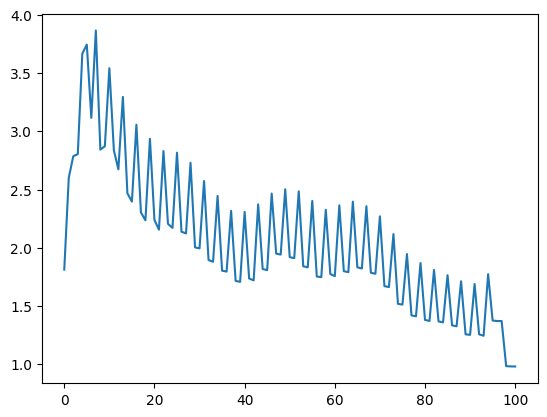

In [195]:
window_size = 10
data = torch.tensor(trainer.losses)
moving_avg = torch.conv1d(
    data.view(1, 1, data.size(0)), 
    torch.ones(1, 1, window_size) / window_size, padding=window_size//2
).squeeze()
plt.plot(moving_avg)

In [215]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [217]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])

In [ ]:
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.05
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
text

'First Citizen:\nVAL!\nIUS:\n\n!\n\n\n\n,'

In [198]:
model.train()
for i in tqdm(range(500)):
    dl = next(trainer.dl_it)
    xs, ys, ms = next(dl)
    xs, ys, ms = xs.to(model.device), ys.to(model.device), ms.to(model.device)
    optimizer.zero_grad()
    try:
        logits, loss = model(xs, ys, ms)
    except:
        continue
    trainer.losses.append(loss.item())
    loss.backward()
    if trainer.scheduler:
        trainer.scheduler.step()
    trainer.optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [292]:
len(trainer.losses[:-100])

1323

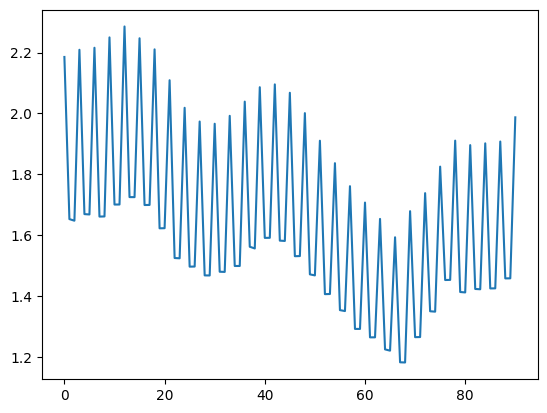

In [295]:
window_size = 10
plt.plot(
    torch.conv1d(
        torch.tensor(trainer.losses[-100:]).view(1, 1, -1),
        torch.ones(1, 1, window_size) / window_size,
    ).squeeze()
)

In [284]:
trainer.losses[-5:]

[0.005202756263315678,
 4.829007148742676,
 0.08367962390184402,
 0.004198835697025061,
 5.293854713439941]

In [283]:
vqa_sample = vqa_dataset[0]
vqa_sample

KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['train', 'validation']"

In [271]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [274]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.05
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
text

'First Citizen:\nA!'

## VQA

In [148]:
model = MiniGato(default_config).to(device)

NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

next(trainer.dl_it)
dl = next(trainer.dl_it)  # Grab the Shakespeare DataLoader.
xs, ys, ms = next(dl)
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

model.train();

optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)

In [149]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
]

In [150]:
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)

In [151]:
dlit = iter(vqa_dataloader)

In [152]:
xs, ys, ms = next(dlit)

In [154]:
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

In [155]:
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)

In [156]:
tokenizer.eot_token_id

50256

In [157]:
(model.lookup_embedding.weight @ seqxs[0, 158]).argmax()

tensor(50256, device='cuda:0')

In [158]:
seqxs.shape, seqys.shape, seqys[0, 158:160], seqxs[0, 158:160]

(torch.Size([4, 1024, 512]),
 torch.Size([4, 1024]),
 tensor([  79, 1647], device='cuda:0'),
 tensor([[-0.3193, -0.1209,  0.8348,  ...,  0.5422,  0.0607, -0.5181],
         [-0.3968,  2.6104, -0.3576,  ..., -0.1462,  0.5124,  0.0510]],
        device='cuda:0', grad_fn=<SliceBackward0>))

In [159]:
(model.lookup_embedding.weight @ seqxs[0, 158]).argmax()

tensor(50256, device='cuda:0')

In [160]:
xs['question'][0, 0, :ms['question'][0, 0].sum().to(int).item()]

tensor([[ 2061],
        [  318],
        [  262],
        [42658],
        [ 2349],
        [  286],
        [  262],
        [32749],
        [ 1444],
        [   30]], device='cuda:0')

In [161]:
tokenizer.decode_text(xs['question'][0, 0, :ms['question'][0, 0].sum().to(int).item()])

'What is the hairstyle of the blond called?'

In [169]:
ys['answer'][0][0], tokenizer.decode_text(ys['answer'][0][0])

(tensor([[   79],
         [ 1647],
         [ 7894],
         [50256]], device='cuda:0'),
 'pony tail<|endoftext|>')

In [163]:
xs['question'].shape, xs['image'].shape

(torch.Size([4, 1, 14, 1]), torch.Size([4, 1, 144, 768]))

In [164]:
xs['question'].shape

torch.Size([4, 1, 14, 1])

In [165]:
model = MiniGato(default_config).to(device)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)

In [166]:
model.train();
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

tensor(10.7650, device='cuda:0', grad_fn=<DivBackward0>)

In [167]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

In [171]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 158:161].topk(5))

0.001622157171368599 torch.return_types.topk(
values=tensor([[7.3778e-01, 2.1006e-01, 4.0938e-02, 1.1084e-02, 1.3479e-04],
        [9.9712e-01, 1.6353e-03, 1.1374e-03, 1.0064e-04, 3.2171e-06],
        [9.4115e-01, 5.4639e-02, 3.8612e-03, 3.5366e-04, 2.3338e-07]],
       device='cuda:0'),
indices=tensor([[   79, 14948,  1507,    65, 50256],
        [ 1647,  5907,     0, 50256,   391],
        [ 7894, 50256,     0,    69,    65]], device='cuda:0'))


## Control

In [174]:
control_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)

In [175]:
dlit = iter(control_dataloader)

In [176]:
xs, ys, ms = next(dlit)

In [177]:
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

In [178]:
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)

In [184]:
xs['mission'].shape, xs['image'].shape, xs['direction'].shape, xs['action'].shape

(torch.Size([4, 6, 3, 1]),
 torch.Size([4, 6, 144, 768]),
 torch.Size([4, 6, 1, 1]),
 torch.Size([4, 6, 1, 1]))

In [191]:
xs['action'][0, -1], tokenizer.decode_discrete(xs['action'][0, -1]), tokenizer.decode_discrete(ys['action'][0, -1])

(tensor([[51280]], device='cuda:0'), [1023], [2])

In [203]:
(model.lookup_embedding.weight @ seqxs[0, 147:151].T).argmax(dim=0)

tensor([11181, 51280, 16250,   262], device='cuda:0')

In [196]:
seqys[0, 147:151]

tensor([    0, 50259,     0,     0], device='cuda:0')

In [204]:
model.train();
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

tensor(0.2623, device='cuda:0', grad_fn=<DivBackward0>)

In [216]:
for _ in tqdm(range(200)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/200 [00:00<?, ?it/s]

In [217]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[:, 148].topk(5))

5.288309694151394e-06 torch.return_types.topk(
values=tensor([[9.9983e-01, 1.4533e-04, 1.6938e-05, 3.9686e-07, 6.1818e-09],
        [9.9982e-01, 1.1422e-04, 5.6065e-05, 6.9599e-07, 1.1287e-08],
        [9.9974e-01, 2.3096e-04, 2.5670e-05, 9.9701e-08, 7.9430e-09],
        [9.9978e-01, 1.0967e-04, 9.2623e-05, 5.2704e-07, 1.4924e-08]],
       device='cuda:0'),
indices=tensor([[50259, 50257, 50258,     0, 20312],
        [50259, 50257, 50258,     0, 20312],
        [50257, 50259, 50258,     0,  9845],
        [50259, 50257, 50258,     0, 20312]], device='cuda:0'))


In [218]:
ys['action'][:, 0]

tensor([[[50259]],

        [[50259]],

        [[50257]],

        [[50259]]], device='cuda:0')

### Visualizing Four Rooms

In [220]:
four_rooms_dataset[0]

EpisodeData(id=0, total_steps=19, observations={direction: ndarray of shape (20,) and dtype int64, image: ndarray of shape (20, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (19,) and dtype int64, rewards=ndarray of 19 floats, terminations=ndarray of 19 bools, truncations=ndarray of 19 bools, infos=dict with the following keys: [])

In [233]:
env = four_rooms_dataset.recover_environment(render_mode='human')

In [225]:
type(env)

gymnasium.wrappers.common.OrderEnforcing

In [235]:
env.reset??

Signature:
env.reset(
    *,
    seed: 'int | None' = None,
    options: 'dict[str, Any] | None' = None,
) -> 'tuple[ObsType, dict[str, Any]]'
Source:   
    def reset(
        self, *, seed: int | None = None, options: dict[str, Any] | None = None
    ) -> tuple[ObsType, dict[str, Any]]:
        """Resets the environment with `kwargs`."""
        self._has_reset = True
        return super().reset(seed=seed, options=options)
File:      ~/.virtualenvs/neko/lib/python3.12/site-packages/gymnasium/wrappers/common.py
Type:      method

In [262]:
obs, _ = env.reset()

In [261]:
obs, reward, terminated, truncated, done = env.step(2)
obs, reward, terminated, truncated, done

({'image': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [231]:
env.render??

Signature: env.render() -> 'RenderFrame | list[RenderFrame] | None'
Source:   
    def render(self) -> RenderFrame | list[RenderFrame] | None:
        """Renders the environment with `kwargs`."""
        if not self._disable_render_order_enforcing and not self._has_reset:
            raise ResetNeeded(
                "Cannot call `env.render()` before calling `env.reset()`, if this is an intended action, "
                "set `disable_render_order_enforcing=True` on the OrderEnforcer wrapper."
            )
        return super().render()
File:      ~/.virtualenvs/neko/lib/python3.12/site-packages/gymnasium/wrappers/common.py
Type:      method

# TODO:

Walk through a demo, using Gym's `env.render` and `env.step`, of the model predicting actions.